<a href="https://colab.research.google.com/github/MoacirB/lia1-2023-1/blob/main/Entrega_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.4 MB/s eta 0:00:00


In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from time import sleep

## Step 1: Download images of birds and non-birds

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Download de fotos de pássaros

In [ ]:
urls = search_images('bird photos', max_images = 1)
urls[0]

Searching for 'bird photos'


'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

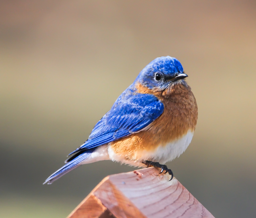

In [ ]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress = False)

im = Image.open(dest)
im.to_thumb(256,256)

### Download de fotos de florestas

Searching for 'forest photos'


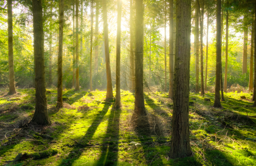

In [ ]:
download_url(search_images('forest photos', max_images = 1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

### Download de fotos de florestas e pássaros para serem usados no treinamento

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(1)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(1)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

### Remove imagens com erro

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

### Cria a entrada para o modelo com as imagens

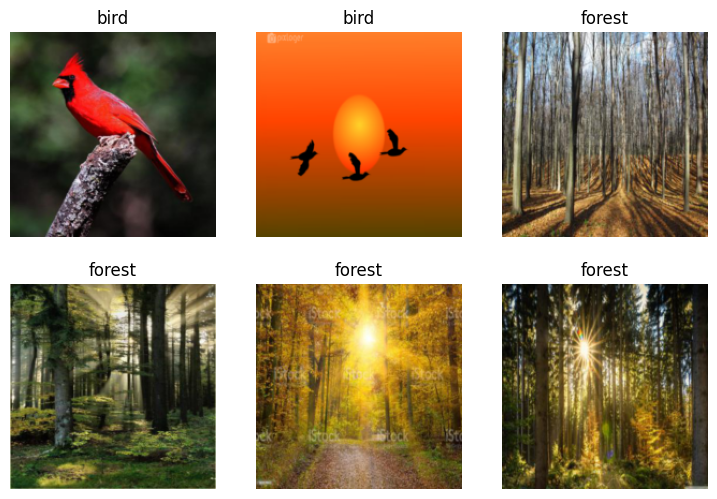

In [ ]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n = 6)

### Treinamento usando resnet18

In [ ]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 262MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.755087,0.269064,0.121212,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.156801,0.064667,0.030303,00:01
1,0.096968,0.069013,0.030303,00:02
2,0.064247,0.055141,0.030303,00:01


## Step 3: Use our model (and build your own!)

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
